## Findings
- Multiple times of cleanings
- Topic Modeling/Recommendation System: Use NMF and Cosine Distance  

Model|Binary|Weight|Cosine|Euclidean|
---|---|---|---|---
LSA|Top Topic: 100%|Top Topic: 80%|-|-
NMF|20 Topics: 2%~12%|1%~15%|Works|The same result
LDA|7 Topics: 0.4%~29%|Top Topic: 94%|Works|Works

- NMF, IF-IDF, Non-binary, cosine best
## Done
- Web-scraping
- Excluded non-English comments
- Topic interpretation

## What to do
- EDA
- Preprocessing
- PCA
- Recommendatin system

In [1747]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation, PCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import nltk
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
import pyLDAvis
import pyLDAvis.sklearn
import re
from corextopic import corextopic as ct
from collections import Counter
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")
import pickle

In [541]:
import spacy
from spacy.symbols import amod
from spacy.language import Language
from spacy_langdetect import LanguageDetector
nlp = spacy.load('en_core_web_sm')

In [3]:
#load data
df = pd.read_csv('comments_clean.csv', index_col=0)
df_stat = pd.read_csv('data/top_1500_stat.csv', index_col=0)
df_game = pd.read_csv('game_clean.csv', index_col=0)

In [1157]:
df_game.head()

,object_id,board_game_rank,clean_com,spacy_doc,docs_clean,pred_topic,clean_twice_comment,topic_pro,title
0,1,312,component moskito edition good complex hard m...,"(component, moskito, edition, good, , complex...","[component, moskito, edition, good, , complex...",17,component moskito edition good complex hard ...,0.094305,Die Macher
1,3,224,simple rule quick gameplay easy teach pretty d...,"(simple, rule, quick, gameplay, easy, teach, p...","[simple, rule, quick, gameplay, easy, teach, p...",6,simple rule quick gameplay easy teach pretty d...,0.189664,Samurai
2,5,286,time play friend house feel like sweep compreh...,"(time, play, friend, house, feel, like, sweep,...","[time, play, friend, house, feel, like, sweep,...",11,time play friend house feel like sweep compreh...,0.190595,Acquire
3,10,1112,truly deserve moniker classic definition cla...,"(truly, deserve, moniker, classic, , definit...","[truly, deserve, moniker, classic, , definit...",6,truly deserve moniker classic definition cl...,0.232141,Elfenland
4,11,464,play player time play feel random engage game ...,"(play, player, time, play, feel, random, engag...","[play, player, time, play, feel, random, engag...",1,play player time play feel random engage game ...,0.099657,Bohnanza


In [1771]:
cv = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5, binary=False, lowercase=True)
X = cv.fit_transform(docs_list_clean)

df_X = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
df_X.head()

,00cc00,100s,10min,10pt,10x,10x10,15min,18chesapeake,18xx,1a,...,zoc,zoch,zolkin,zombicide,zombie,zombies,zone,zoo,zooloretto,zoom
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.018596,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.039294,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1409]:
df_X.sum().sum()

20470.077349279716

In [1410]:
df_X.sum().sort_values(ascending=False)

card            198.616152
star            106.908176
dice             67.995748
nostar           67.474810
action           60.470733
                   ...    
recheck           0.076893
apiece            0.074666
unconvinced       0.073892
accomplished      0.073372
faithfully        0.070277
Length: 12848, dtype: float64

## Topic Modeling - NMF

In [959]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [1553]:
nmf = NMF(21, random_state=51)
doc_topic = nmf.fit_transform(X)

In [1554]:
topic_word = pd.DataFrame(nmf.components_.round(3),
             columns = cv.get_feature_names())
topic_word

,00cc00,100s,10min,10pt,10x,10x10,15min,18chesapeake,18xx,1a,...,zoc,zoch,zolkin,zombicide,zombie,zombies,zone,zoo,zooloretto,zoom
0,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.025,0.009,0.000,0.000,0.000
1,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.003,0.000,0.000,0.000,0.000,0.007,0.000,0.017,0.001
2,0.001,0.000,0.000,0.000,0.001,0.001,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.009,0.000,0.000,0.003,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,...,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001
5,0.000,0.000,0.002,0.001,0.000,0.000,0.000,0.000,0.000,0.001,...,0.013,0.000,0.000,0.000,0.000,0.000,0.016,0.000,0.000,0.006
6,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.006,0.000,0.000
7,0.001,0.000,0.003,0.001,0.000,0.001,0.001,0.000,0.000,0.000,...,0.000,0.001,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.000
8,0.000,0.001,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.002
9,0.003,0.005,0.000,0.002,0.000,0.000,0.001,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.003


In [1576]:
topic_word.sum().sample(60).sort_values(ascending=False)

win                 1.414
attack              0.804
room                0.726
quickly             0.469
watch               0.310
night               0.306
impression          0.253
outcome             0.179
today               0.133
crossroad           0.126
holmes              0.126
murderer            0.121
inside              0.114
standalone          0.103
tack                0.089
ocean               0.070
broken              0.056
epidemic            0.049
derivative          0.047
lately              0.046
pump                0.043
hq                  0.041
adversary           0.039
mayday              0.038
vocabulary          0.038
claw                0.035
meadow              0.033
poseidon            0.033
wacky               0.032
rice                0.032
cardplay            0.032
2player             0.031
pete                0.031
ban                 0.027
bread               0.027
stance              0.027
devour              0.026
atb                 0.025
decidedly   

In [1556]:
display_topics(nmf, cv.get_feature_names(), 10)


Topic  0
faction, smash, coin, control, summoner, alliance, dune, expansion, area, war

Topic  1
star, nostar, ize, size, halfstar, x2, x1, gg, x5, thumbsup

Topic  2
card, hand, draft, draw, round, luck, score, filler, discard, set

Topic  3
dungeon, monster, character, hero, quest, scenario, adventure, campaign, story, miniature

Topic  4
dice, roll, die, luck, yahtzee, solo, write, number, use, high

Topic  5
unit, war, wargame, battle, scenario, combat, army, asl, memoir, map

Topic  6
tile, carcassonne, scoring, score, city, castle, place, lie, azul, board

Topic  7
clue, deduction, word, party, werewolf, team, guess, role, codename, people

Topic  8
auction, bid, bidding, money, ra, round, win, blind, knizia, value

Topic  9
civ, civilization, resource, building, city, build, tech, military, technology, race

Topic  10
puzzle, exit, escape, unlock, solve, series, hint, room, clue, app

Topic  11
company, 18xx, stock, train, share, market, money, dividend, track, loan

Topic  12


In [1557]:
doc_topic

array([[6.10696279e-03, 0.00000000e+00, 5.35404182e-02, ...,
        3.55279213e-03, 0.00000000e+00, 0.00000000e+00],
       [2.94037958e-03, 1.77055137e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.78216018e-03, ...,
        2.79813262e-04, 2.10308642e-03, 0.00000000e+00],
       ...,
       [0.00000000e+00, 2.93448368e-01, 1.78535245e-02, ...,
        0.00000000e+00, 3.54039335e-02, 0.00000000e+00],
       [7.55619078e-04, 1.44405070e-01, 9.73571118e-02, ...,
        0.00000000e+00, 7.74154182e-03, 7.01552618e-03],
       [4.30261064e-02, 0.00000000e+00, 2.16072286e-01, ...,
        0.00000000e+00, 5.86142092e-04, 0.00000000e+00]])

In [1558]:
df_game['pred_topic'] = doc_topic.argmax(axis=1)
df_game['topic_pro'] = doc_topic.max(axis=1)
df_game

,object_id,board_game_rank,clean_com,spacy_doc,docs_clean,pred_topic,clean_twice_comment,topic_pro,title
0,1,312,component moskito edition good complex hard m...,"(component, moskito, edition, good, , complex...","[component, moskito, edition, good, , complex...",17,component moskito edition good complex hard ...,0.094305,Die Macher
1,3,224,simple rule quick gameplay easy teach pretty d...,"(simple, rule, quick, gameplay, easy, teach, p...","[simple, rule, quick, gameplay, easy, teach, p...",6,simple rule quick gameplay easy teach pretty d...,0.189664,Samurai
2,5,286,time play friend house feel like sweep compreh...,"(time, play, friend, house, feel, like, sweep,...","[time, play, friend, house, feel, like, sweep,...",11,time play friend house feel like sweep compreh...,0.190595,Acquire
3,10,1112,truly deserve moniker classic definition cla...,"(truly, deserve, moniker, classic, , definit...","[truly, deserve, moniker, classic, , definit...",6,truly deserve moniker classic definition cl...,0.232141,Elfenland
4,11,464,play player time play feel random engage game ...,"(play, player, time, play, feel, random, engag...","[play, player, time, play, feel, random, engag...",1,play player time play feel random engage game ...,0.099657,Bohnanza
...,...,...,...,...,...,...,...,...,...
1495,319966,599,harsh rating comment king siam appear king d...,"(harsh, rating, comment, king, siam, appear, ...","[harsh, rating, comment, king, siam, appear, ...",17,harsh rating comment king siam appear king ...,0.167859,The King is Dead: Second Edition
1496,322708,999,skeptical get quest game app wonderful job...,"(skeptical, get, , quest, game, , app, won...","[skeptical, , quest, game, , app, wonderfu...",3,skeptical quest game app wonderful job r...,0.171764,Descent: Legends of the Dark
1497,324856,625,improvement original fantastic like mission ...,"(improvement, original, fantastic, , like, m...","[improvement, original, fantastic, , like, m...",1,improvement original fantastic like mission...,0.293448,The Crew: Mission Deep Sea
1498,328871,561,prettier production bad original game phase se...,"(prettier, production, bad, original, game, ph...","[pretty, production, bad, original, game, phas...",1,pretty production bad original game phase sele...,0.144405,Terraforming Mars: Ares Expedition


In [1559]:
df_game['pred_topic'].value_counts()/1500

2     0.152667
17    0.082667
5     0.074000
1     0.071333
4     0.067333
3     0.061333
7     0.058667
6     0.054000
14    0.052667
15    0.049333
13    0.044000
16    0.040667
12    0.034000
8     0.030000
0     0.023333
19    0.020667
9     0.018667
20    0.017333
18    0.017333
11    0.016667
10    0.013333
Name: pred_topic, dtype: float64

In [1145]:
topic_21 = ['strategy_wargame', 'family_cardgame', 'card_drafting', 'thematic_dungeons', 'dice_rolling',
            'wargame', 'city_building', 'party_word', 'auction_bidding', 'civilization', 'puzzle', 'trains', 
            'ship_space', 'startegy_scifi', 'deck_building', 'abstract', 'adventure', 'strategy_economic',
            'animal_family_children', 'zombie', 'ticket_to_ride']

## Standardization

In [1413]:
scaler = StandardScaler()

In [1415]:
X_std = scaler.fit_transform(X.toarray())

## PCA

In [1335]:
#pickle.dump(X_proj, open('pca_proj.pkl', 'wb'))

In [1772]:
pca = PCA()
X_proj = pca.fit_transform(X.toarray())
#X_proj = pca.fit_transform(X_std)

In [1773]:
def show_variance_explained_plots(pca):
    
    var_exp_array = pca.explained_variance_ratio_
    n_comps = var_exp_array.shape[0] 
    
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    ax[0].fill_between(range(n_comps), var_exp_array)
    ax[0].set_title('Variance Explained by Nth Principal Component')
    
    ax[1].fill_between(range(n_comps), np.cumsum(var_exp_array))
    ax[1].set_title('Cumulative Variance Explained by N Components')
    plt.savefig('pca.png', dpi=400, facecolor='w', bbox_inches='tight')
    plt.show()
    

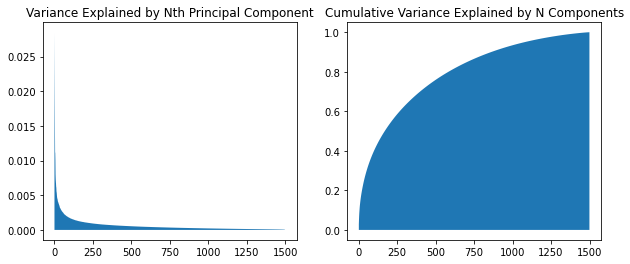

In [1774]:
show_variance_explained_plots(pca)

In [1456]:
pca = PCA(600)
X_proj = pca.fit_transform(X.toarray())

## Recommendation System Testing

In [1363]:
#Dungeons & Dragons
t21 = """Each player selects a hero; a ranger, rogue, warrior, cleric, or wizard. 
        On their turn, each player can explore further into the dungeon (turn over new tiles), 
        move through the already explored parts of the dungeon, and fight monsters. When a new dungeon tile 
        is revealed, there is typically an encounter of some sort, and new monsters to fight are added. 
        Slain monsters reward the players with treasure, and experience points, allowing them to level up and 
        increase their skills during play. Players must cooperate to stay alive, slay the monsters, and achieve 
        the goal of their quest. Each scenario has a different goal - from retrieving a relic, to slaying a 
        vampire lord."""
# kid
t22 = """I like to explore a new short fun cute card game with my family and little children. kids
        Easy to understand. toddler"""

# split island
t23 = """Spirit Island is a complex and thematic cooperative game about defending your 
        island home from colonizing Invaders. Players are different spirits of the land, 
        each with its own unique elemental powers. Every turn, players simultaneously choose 
        which of their power cards to play, paying energy to do so. Using combinations of power cards 
        that match a spirit's elemental affinities can grant free bonus effects. Faster powers take effect 
        immediately, before the Invaders spread and ravage, but other magics are slower, requiring forethought 
        and planning to use effectively. In the Spirit phase, spirits gain energy, and choose how / whether to 
        Grow: to reclaim used power cards, to seek for new power, or to spread presence into new areas of the 
        island."""

#Sushi go
t24 = '''Sushi Go! takes the card-drafting mechanism of Fairy Tale and 7 Wonders and distills 
        it into a twenty-minute game that anyone can play. The dynamics of "draft and pass" 
        are brought to the fore, while keeping the rules to a minimum. As you see the first few 
        hands of cards, you must quickly assess the make-up of the round and decide which type of sushi you'll 
        go for. Then, each turn you'll need to weigh which cards to keep and which to pass on. 
        The different scoring combinations allow for some clever plays and nasty blocks. Round to round, 
        you must also keep your eye on the goal of having the most pudding cards at the end of the game!'''

#
t25 = '''I like play puzzle game with friends like escape a room, find the murder'''

t26 = '''coloretto'''


In [1260]:
#Topic  0
t0 = 'faction, smash, coin, control, summoner, alliance, dune, expansion, area, war'

#Topic  1
t1 = 'star, nostar, ize, size, halfstar, x2, x1, gg, x5, thumbsup'

#Topic  2
t2 = 'card, hand, draft, draw, round, luck, score, filler, discard, set'

#Topic  3
t3 = 'dungeon, monster, character, hero, quest, scenario, adventure, campaign, story, miniature'

#Topic  4
t4 = 'dice, roll, die, luck, yahtzee, solo, write, number, use, high'

#Topic  5
t5 = 'unit, war, wargame, battle, scenario, combat, army, asl, memoir, map'

#Topic  6
t6 = 'tile, carcassonne, scoring, score, city, castle, place, lie, azul, board'

#Topic  7
t7 = 'clue, deduction, word, party, werewolf, team, guess, role, codename, people'

#Topic  8
t8 = 'auction, bid, bidding, money, ra, round, win, blind, knizia, value'

#Topic  9
t9 = 'civ, civilization, resource, building, city, build, tech, military, technology, race'

#Topic  10
t10 = 'puzzle, exit, escape, unlock, solve, series, hint, room, clue, app'

#Topic  11
t11 = 'company, 18xx, stock, train, share, market, money, dividend, track, loan'

#Topic  12
t12 = 'ship, pirate, wing, alien, planet, captain, trek, crew, space, fleet'

#Topic  13
t13 = 'worker, placement, resource, building, action, build, caylus, round, euro, place'

#Topic  14
t14 = 'deck, card, dominion, building, expansion, builder, ascension, deckbuilde, villain, deckbuilder'

#Topic  15
t15 = 'piece, abstract, dexterity, board, chess, flick, tower, nostar, opponent, gipf'

#Topic  16
t16 = 'pandemic, legacy, story, campaign, op, solo, cooperative, ghost, island, character'

#Topic  17
t17 = 'action, cube, area, board, euro, feld, control, round, rondel, selection'

#Topic  18
t18 = 'animal, agricola, kid, specie, zooloretto, ize, enclosure, dinosaur, zoo, adult'

#Topic  19
t19 = 'zombie, zombicide, survivor, alien, scenario, mission, weapon, marine, traitor, human'

#Topic  20
t20 = 'ticket, route, ttr, train, ride, passenger, city, map, europe, destination'

In [1430]:
t = t26.replace("\n",' ')
#t = str(TextBlob(t).correct())
t_nlp = [[w.lemma_.lower() for w in nlp(t) 
          if not w.is_stop and not w.is_punct and not w.like_num]]

t_clean= [' '.join(w) for w in t_nlp]
t_clean

['coloretto']

In [1431]:
vt = cv.transform(t_clean)

In [1432]:
tt = pca.transform(vt.toarray())
#tt = nmf.transform(vt)

In [ ]:
pairwise_distances(tt,doc_topic,metric='cosine').argsort()

In [1433]:
cos = pairwise_distances(tt,X_proj,metric='cosine').argsort()
#cos = pairwise_distances(tt,doc_topic,metric='cosine').argsort()
for g in cos[0][:10]:
    print(df[['object_id','board_game_rank', 'title']][df['object_id'] ==  df_game.object_id.loc[g]].head(1))

       object_id  board_game_rank      title
20966       5782              563  Coloretto
       object_id  board_game_rank       title
30002      27588              812  Zooloretto
       object_id  board_game_rank  title
36998       8989             1013  Hansa
       object_id  board_game_rank      title
47594      34194             1326  Aquaretto
       object_id  board_game_rank     title
24257     200147              653  Kanagawa
       object_id  board_game_rank     title
33841     228504              922  Cat Lady
       object_id  board_game_rank                     title
10562      59959              283  Letters from Whitechapel
       object_id  board_game_rank     title
35539     145639              970  Coconuts
      object_id  board_game_rank                      title
9222      93260              247  Summoner Wars: Master Set
       object_id  board_game_rank  title
18680       2346              500  DVONN


In [1434]:
cos = pairwise_distances(tt,X_proj,metric='euclidean').argsort()
#cos = pairwise_distances(tt,doc_topic,metric='euclidean').argsort()
for g in cos[0][:10]:
    print(df[['object_id','board_game_rank', 'title']][df['object_id'] ==  df_game.object_id.loc[g]].head(1))

       object_id  board_game_rank      title
20966       5782              563  Coloretto
       object_id  board_game_rank       title
30002      27588              812  Zooloretto
       object_id  board_game_rank     title
24257     200147              653  Kanagawa
       object_id  board_game_rank  title
36998       8989             1013  Hansa
       object_id  board_game_rank      title
47594      34194             1326  Aquaretto
       object_id  board_game_rank     title
22171        432              596  6 nimmt!
       object_id  board_game_rank     title
33841     228504              922  Cat Lady
       object_id  board_game_rank      title
16962       9674              454  Ingenious
       object_id  board_game_rank   title
20754         46              557  Medici
       object_id  board_game_rank                     title
43990     205418             1218  Agricola: Family Edition


## prepare data for app

In [1189]:
title = df[['object_id', 'title']].drop_duplicates().sort_values('object_id').reset_index(drop=True)

In [1616]:
df_stat['com_age'] = df_stat[['age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_8', 'age_10', 'age_12', 'age_14',
                              'age_16', 'age_18','age_21']].idxmax(1).map(lambda x:x[4:]).astype('int')

In [1608]:
title= title.merge(df_stat[['object_id', 'year', 'minplayers', 'maxplayers', 'minplaytime', 
                            'maxplaytime', 'age', 'owned','com_age']],on = 'object_id')

In [1663]:
title= title.merge(df[['object_id','avg_rating']].drop_duplicates(),on = 'object_id')

In [1703]:
title.describe()

,object_id,year,minplayers,maxplayers,minplaytime,maxplaytime,age,owned,com_age,geek_rating,avg_rating
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,139470.713333,2011.626000,1.864667,4.960667,62.300000,105.040000,11.395333,11963.864667,10.550000,6.792886,7.391973
std,95066.747096,8.217084,0.692824,6.038827,54.702037,363.644518,2.325220,15667.833580,2.333909,0.410918,0.426390
min,1.000000,1980.000000,1.000000,0.000000,2.000000,2.000000,0.000000,359.000000,2.000000,6.289000,6.490000
25%,39253.250000,2009.000000,1.000000,4.000000,30.000000,45.000000,10.000000,4125.500000,8.000000,6.468000,7.067500
50%,154144.500000,2014.000000,2.000000,4.000000,45.000000,60.000000,12.000000,6608.000000,10.000000,6.694000,7.350000
75%,217800.250000,2017.000000,2.000000,5.000000,60.000000,120.000000,13.000000,12744.500000,12.000000,7.033500,7.670000
max,329465.000000,2021.000000,8.000000,100.000000,720.000000,12000.000000,18.000000,164578.000000,18.000000,8.523000,8.870000


In [1682]:
title.loc[title.object_id == 244522]
#title.loc[title.year <1980, 'year'] = 1980

,object_id,title,year,minplayers,maxplayers,minplaytime,maxplaytime,age,owned,com_age,geek_rating,avg_rating
1255,244522,That's Pretty Clever!,2018,1,4,30,30,8,25509,8,7.409,7.63


In [1709]:
title[(title['avg_rating'] >= 6) &
                  (title['year'] >= 1980) & (title['year'] <= 2021) &
                  (title['minplayers'] >= 1) & (title['maxplayers'] <= 100) & 
                  (title['minplaytime'] >= 2) & (title['maxplaytime'] <= 12000) &
                  (title['age'] >= 0) & (title['age'] <= 18) &
                  (title['com_age'] >= 0) & (title['com_age'] <= 18) &
                  (title['owned'] >= 300) & (title['owned'] <= 165000)]

,object_id,title,year,minplayers,maxplayers,minplaytime,maxplaytime,age,owned,com_age,geek_rating,avg_rating
0,1,Die Macher,1986,3,5,240,240,14,7438,14,7.104,7.61
1,3,Samurai,1998,2,4,30,60,10,15524,10,7.240,7.46
2,5,Acquire,1980,2,6,90,90,12,23625,12,7.143,7.34
3,10,Elfenland,1998,2,6,60,60,10,10063,8,6.479,6.70
4,11,Bohnanza,1997,2,7,45,45,13,59292,8,6.934,7.04
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,319966,The King is Dead: Second Edition,2020,2,4,30,45,14,4410,10,6.800,7.88
1496,322708,Descent: Legends of the Dark,2021,1,4,120,180,14,2910,10,6.537,7.96
1497,324856,The Crew: Mission Deep Sea,2021,2,5,20,20,10,4373,10,6.786,8.46
1498,328871,Terraforming Mars: Ares Expedition,2021,1,4,45,60,14,6606,12,6.836,7.65


In [1678]:
#title = pickle.load(open('pickles/title.pkl', 'rb'))
#pickle.dump(title, open('title.pkl', 'wb'))

## K-means

In [1756]:
pca = PCA(2)
X_proj = pca.fit_transform(X.toarray())

In [1757]:
X_proj

array([[-0.08060899,  0.00367853],
       [ 0.40275405, -0.18402593],
       [-0.05959412, -0.1495126 ],
       ...,
       [ 0.62642875, -0.10892906],
       [ 0.28998189,  0.09547544],
       [-0.07059865,  0.36456337]])

In [1767]:
def display_cluster(X,km=[],num_clusters=0):
    cm = plt.get_cmap('gist_rainbow')
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = cm(i/num_clusters),alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = cm(i/num_clusters), marker = 'x', s = 100)
        sns.despine()
        plt.savefig('k_mean.png', dpi=400, facecolor='w', bbox_inches='tight')

In [1765]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)
        sns.despine()
        plt.savefig('k_mean.png', dpi=400, facecolor='w', bbox_inches='tight')

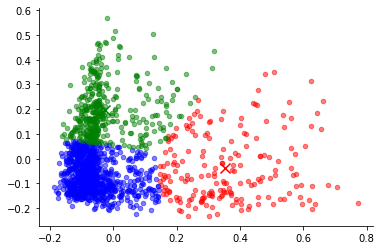

In [1766]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(X_proj)
display_cluster(X_proj,km,num_clusters)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

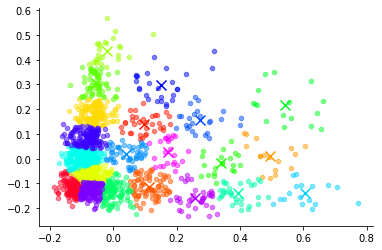

In [1770]:
num_clusters = 21
km = KMeans(n_clusters=num_clusters)
km.fit(X_proj)
display_cluster(X_proj,km,num_clusters)

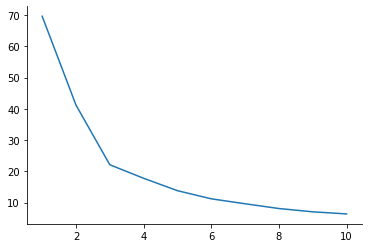

In [1760]:
inertia = []
for num_clusters in range(1,11):
    km = KMeans(n_clusters=num_clusters)
    km.fit(X_proj)
    inertia.append(km.inertia_)
plt.plot(range(1,11), inertia)
sns.despine()
plt.savefig('k_mean.png', dpi=400, facecolor='w', bbox_inches='tight')

## Corex

In [ ]:
cv = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5, binary=False, lowercase=True)
X = cv.fit_transform(docs_list_clean)

df_X = pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
df_X.head()

In [1717]:
corex = ct.Corex(n_hidden=21, words=cv.get_feature_names(),
                       max_iter=200, verbose=False, seed=1)


In [1718]:
corex.fit(X, words=cv.get_feature_names(), docs=docs_list_clean)
#anchors=[['nasa', 'politics'], 'nasa'], anchor_strength=10

In [1720]:
for n,topic in enumerate(corex.get_topics()):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: wargame,unit,asl,war,cdg,axis,historical,memoir,infantry,squad
1: dungeon,character,monster,hero,crawler,scenario,miniature,quest,zombicide,marine
2: clue,exit,werewolf,dixit,codename,deduction,puzzle,word,party,hint
3: 18xx,company,stock,train,steam,brass,dividend,share,merger,aos
4: agricola,uwe,rosenberg,wine,havre,caverna,le,viticulture,tuscany,dike
5: villain,villainous,dc,marvel,superhero,disney,pete,legendary,quarrior,mastermind
6: ticket,ttr,passenger,route,ride,marklin,destination,nordic,europe,transamerica
7: timeline,gipf,dvonn,yinsh,tzaar,invention,zertz,cinema,date,tamsk
8: horror,arkham,investigator,haunt,betrayal,cthulhu,eldritch,mythos,mansion,lovecraft
9: specie,eklund,climate,carnivore,evolution,pax,megafauna,trait,phil,porfiriana
10: flick,dexterity,pitchcar,crokinole,catacomb,flicking,penguin,magnet,disc,car
11: que,pret,en,pope,porter,cardinal,fashion,por,lo,más
12: dune,eclipse,4x,rex,alliance,trek,tech,ti3,imperium,planet
13: 2d,portal,polo,pointing,pointer,pn